In [11]:
import nltk
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Data Loading and Preprocessing

In [2]:
# Load your clean data
df = pd.read_csv('../data/clean/clean_data.csv')

In [3]:
df.head(2)

,ProductId,Rating,Summary,Text,Review,processed_text
0,B0088YBUOU,2,I like these!,These are actually very tasty. Pure potatoes ...,I like these!. These are actually very tasty. ...,like actually tasty pure potato great texture ...
1,B000Q75354,2,Good but subjectively not 5 star,I realize that taste is a matter of personal p...,Good but subjectively not 5 star. I realize th...,good subjectively star realize taste matter pe...


In [4]:

# Preprocessing specifically for LSTM
def preprocess_for_lstm(texts):
    
    return texts

# Prepare sequences
max_features = 5000  # Top words to consider
max_len = 200  # Max sequence length

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['processed_text'])
sequences = tokenizer.texts_to_sequences(df['processed_text'])
X = pad_sequences(sequences, maxlen=max_len)
y = df['Rating']  #sentiment labels

# Save tokenizer for later use
import joblib
joblib.dump(tokenizer, '../models/lstm_tokenizer.pkl')


['../models/lstm_tokenizer.pkl']

Build the Model

In [6]:
# Build LSTM model
def build_lstm_model(vocab_size, embedding_dim=128, lstm_units=64):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # 3 classes: Negative, Neutral, Positive
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# Get vocabulary size
vocab_size = min(max_features, len(tokenizer.word_index) + 1)

# Create and train model
model = build_lstm_model(vocab_size)


c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Train and evaluate 

In [ ]:


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping]
)

# Evaluate
results = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {results[1]:.4f}")

# Save model
model.save('../models/lstm_sentiment_model.h5')


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.7393 - loss: 0.8078 - val_accuracy: 0.7750 - val_loss: 0.6515
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.8007 - loss: 0.5739 - val_accuracy: 0.8125 - val_loss: 0.5486
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.8888 - loss: 0.3237 - val_accuracy: 0.8175 - val_loss: 0.5954
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.9142 - loss: 0.2523 - val_accuracy: 0.8275 - val_loss: 0.6311
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9238 - loss: 0.1976 - val_accuracy: 0.8225 - val_loss: 0.6868
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7959 - loss: 0.8157


Test Accuracy: 0.8050


Visualize 


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


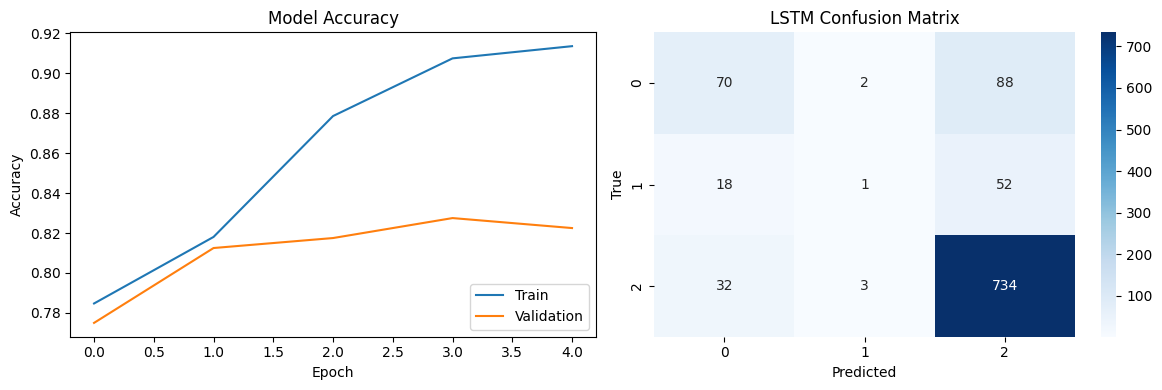

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Confusion matrix
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [13]:
def predict_sentiment(text, tokenizer, model):
    # Preprocess
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len)
    
    # Predict
    prediction = model.predict(padded)[0]
    predicted_class = prediction.argmax()
    
    # Map to sentiment
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_map[predicted_class], prediction[predicted_class]

# Test with sample reviews
samples = [
    "This product is amazing, I love it!",
    "The quality is terrible, don't waste your money.",
    "It's okay, nothing special but not bad either."
]

for sample in samples:
    sentiment, confidence = predict_sentiment(sample, tokenizer, model)
    print(f"Text: {sample}")
    print(f"Sentiment: {sentiment} (Confidence: {confidence:.2f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Text: This product is amazing, I love it!
Sentiment: Positive (Confidence: 0.90)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Text: The quality is terrible, don't waste your money.
Sentiment: Negative (Confidence: 0.84)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Text: It's okay, nothing special but not bad either.
Sentiment: Negative (Confidence: 0.85)

